<a href="https://colab.research.google.com/github/mostafa-ja/Anomaly-detection/blob/main/autoencoder_fooladi_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install -U sentence-transformers

In [66]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [67]:
import re
import string
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
import pandas as pd
import json
from sklearn.metrics.pairwise import cosine_similarity
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os

# Set seed for PyTorch
torch.manual_seed(42)
# Set seed for NumPy
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
# upload HDFS dataset
!wget 'https://zenodo.org/record/3227177/files/HDFS_1.tar.gz'
!tar -xzvf "/content/HDFS_1.tar.gz" -C "/content/"   #unzip the file


--2024-01-04 18:35:30--  https://zenodo.org/record/3227177/files/HDFS_1.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3227177/files/HDFS_1.tar.gz [following]
--2024-01-04 18:35:31--  https://zenodo.org/records/3227177/files/HDFS_1.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 161886385 (154M) [application/octet-stream]
Saving to: ‘HDFS_1.tar.gz.1’

HDFS_1.tar.gz.1     100%[===================>] 154.39M  17.5MB/s    in 11s     

2024-01-04 18:35:42 (13.8 MB/s) - ‘HDFS_1.tar.gz.1’ saved [161886385/161886385]

HDFS.log
anomaly_label.csv


In [69]:
# count rows of the raw log

with open('/content/HDFS.log', "r") as file:
    totaln=0
    for line in file:
        totaln += 1

print('There are a total of {} lines'.format(totaln))

There are a total of 11175629 lines


In [70]:
def clean(s):
    """ Preprocess log message
    Parameters
    ----------
    s: str, raw log message

    Returns
    -------
    str, preprocessed log message without number tokens and special characters
    """
    # s = re.sub(r'(\d+\.){3}\d+(:\d+)?', " ", s)
    # s = re.sub(r'(\/.*?\.[\S:]+)', ' ', s)
    s = re.sub('\]|\[|\)|\(|\=|\,|\;', ' ', s)
    s = " ".join([word.lower() if word.isupper() else word for word in s.strip().split()])
    s = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', s))
    s = " ".join([word for word in s.split() if not bool(re.search(r'\d', word))])
    trantab = str.maketrans(dict.fromkeys(list(string.punctuation)))
    content = s.translate(trantab)
    s = " ".join([word.lower().strip() for word in content.strip().split()])
    return s

def find_blockid(text):
  match = re.search(r"blk_[-\w]+", text)
  return match.group()


In [71]:
def structured(address):
  with open(address, "r") as file:

      log2index = {}    # give for each unique cleaned log an index
      index2embed = {}  # give for each index(belongs to a unique cleaned log) sentence embedding of that unique cleaned log
      blockId_logs = {} # gather logs(index) which are blong to a specific block id
      index = -1

      for line in file:

        blockId = find_blockid(line)
        if not blockId in blockId_logs:
              blockId_logs[blockId] = []

        cleaned_line = clean(line)

        i = log2index.get(cleaned_line) # i is the index of the cleaned log
        if i is None:
            index += 1
            log2index[cleaned_line] = index
            index2embed[index] = model.encode(cleaned_line)
            blockId_logs[blockId].append(index)
        else :
            blockId_logs[blockId].append(i)


  embeddings = np.array(list(index2embed.values()))


  return log2index, embeddings, blockId_logs


In [72]:
log2index, embeddings, blockId_logs = structured('/content/HDFS.log')


In [73]:
print('number of templates : ',len(log2index))

number of templates :  52


In [74]:
log2index

{'info dfs data node data xceiver receiving block src dest': 0,
 'info dfs fs namesystem block name systemallocate block': 1,
 'info dfs data node packet responder packet responder for block terminating': 2,
 'info dfs data node packet responder received block of size from': 3,
 'info dfs fs namesystem block name systemadd stored block block map updated is added to size': 4,
 'info dfs data node data xceiver received block src dest of size': 5,
 'info dfs data node data transfer transmitted block to': 6,
 'info dfs data node starting thread to transfer block to': 7,
 'info dfs fs namesystem block ask to replicate to datanode s': 8,
 'info dfs data node data xceiver served block to': 9,
 'info dfs data block scanner verification succeeded for': 10,
 'info dfs data node data xceiver write block received exception javanet socket timeout exception': 11,
 'info dfs data node packet responder packet responder exception javaio eof exception': 12,
 'info dfs data node data xceiver write block 

In [75]:
data_df = pd.DataFrame(list(blockId_logs.items()), columns=['BlockId', 'EventSequence'])
data_df.to_csv("HDFS_sequence.csv",index=None)

In [76]:
data_df.head()

,BlockId,EventSequence
0,blk_-1608999687919862906,"[0, 1, 0, 0, 2, 2, 3, 3, 2, 3, 4, 4, 4, 5, 0, ..."
1,blk_7503483334202473044,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 9, 10,..."
2,blk_-3544583377289625738,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 9, 4, 4, 4, 9, ..."
3,blk_-9073992586687739851,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10..."
4,blk_7854771516489510256,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10..."


In [77]:
labels = pd.read_csv('/content/anomaly_label.csv')
labels.head()

,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


In [78]:
# Merge the labels with the data_df DataFrame
data_df = data_df.merge(labels, on='BlockId', how='left')
data_df.head(3)

,BlockId,EventSequence,Label
0,blk_-1608999687919862906,"[0, 1, 0, 0, 2, 2, 3, 3, 2, 3, 4, 4, 4, 5, 0, ...",Normal
1,blk_7503483334202473044,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 9, 10,...",Normal
2,blk_-3544583377289625738,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 9, 4, 4, 4, 9, ...",Anomaly


In [79]:
# Splitting the dataset into train and test
hdfs_sequence_normal = data_df[data_df['Label'] == 'Normal']

hdfs_sequence_abnormal = data_df[data_df['Label'] != 'Normal']

# Print the lengths of train and test datasets
print("Normal Dataset Length:", len(hdfs_sequence_normal))
print("Abnormal Test Dataset Length:", len(hdfs_sequence_abnormal))

Normal Dataset Length: 558223
Abnormal Test Dataset Length: 16838


In [80]:
hdfs_sequence_normal.head(3)

,BlockId,EventSequence,Label
0,blk_-1608999687919862906,"[0, 1, 0, 0, 2, 2, 3, 3, 2, 3, 4, 4, 4, 5, 0, ...",Normal
1,blk_7503483334202473044,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 9, 10,...",Normal
3,blk_-9073992586687739851,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10...",Normal


In [81]:
hdfs_sequence_abnormal.head(3)

,BlockId,EventSequence,Label
2,blk_-3544583377289625738,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 9, 4, 4, 4, 9, ...",Anomaly
15,blk_-8531310335568756456,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10...",Anomaly
23,blk_3947106522258141922,"[0, 0, 1, 0, 2, 3, 2, 3, 4, 4, 2, 3, 4, 10, 10...",Anomaly


In [82]:
# Calculate the split indices based on the desired ratio
total_rows = len(hdfs_sequence_normal)
train_ratio = 0.90
train_rows = int(total_rows * train_ratio)

# Split the DataFrame into training and testing sets
train_hdfs_sequence_normal = hdfs_sequence_normal.iloc[:train_rows]
test_hdfs_sequence_normal = hdfs_sequence_normal.iloc[train_rows:]

print("Normal train Dataset Length:", len(train_hdfs_sequence_normal))
print("Normal Test Dataset Length:", len(test_hdfs_sequence_normal))


Normal train Dataset Length: 502400
Normal Test Dataset Length: 55823


In [83]:

# Explode the lists into separate rows
exploded_df = train_hdfs_sequence_normal.explode('EventSequence')

# Get unique index of templates in train dataset
unique_index = list(exploded_df['EventSequence'].unique())
unique_index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 31, 14, 10, 34, 33, 32, 18]

In [84]:
# use just train data's indices(unique_index) for pca
pca = PCA(n_components=0.90)
pca.fit(embeddings[unique_index])
reduced_embeddings = pca.transform(embeddings)


In [85]:
print('word embedding size(before pca) : ',embeddings[0].shape)
print('word embedding size(after pca) : ',reduced_embeddings[0].shape)

word embedding size(before pca) :  (384,)
word embedding size(after pca) :  (10,)


In [86]:
import torch
import torch.nn as nn

class MLPAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(MLPAutoencoder, self).__init__()
        self.sequence_length = sequence_length
        self.input_dim = input_dim

        # Encoder layers with dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Dropout layer
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )

        # Decoder layers with dropout
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Dropout layer
            nn.Linear(hidden_dim * 2, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [87]:
reduced_embeddings[0].shape[0]

10

In [113]:
# Define the dimensions
embed_dim = reduced_embeddings[0].shape[0]
sequence_length = 5
input_dim = embed_dim * sequence_length
hidden_dim = 20
dropout_prob = 0.1  # You can adjust this as needed

batch_size = 32

# Generating random input data for demonstration
input_data = torch.randn(batch_size, input_dim).to(device)

# Create the GRU Autoencoder model
model = MLPAutoencoder(input_dim, hidden_dim, dropout_prob).to(device)

# Forward pass through the model
output = model(input_data)

# Check the shape of the output
print("Output shape:", output.shape)


Output shape: torch.Size([32, 50])


In [89]:
# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of Parameters: {num_params}")

Number of Parameters: 5750


In [90]:
name = 'logs_train'
window_size=sequence_length
num_sessions = 0
inputs = []
for log in train_hdfs_sequence_normal['EventSequence']:
   num_sessions += 1
   line = [ reduced_embeddings[int(i)] for i in log]
   for i in range(len(line) - window_size):
      inputs.append(line[i:i + window_size])

print('Number of sessions({}): {}'.format(name, num_sessions))
print('Number of seqs({}): {}'.format(name, len(inputs)))

dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float))

Number of sessions(logs_train): 502400
Number of seqs(logs_train): 7427816


In [91]:
batch_size=256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataloader) # regarding to batch size

29015

In [92]:
for step, (seq) in enumerate(dataloader):
  print(seq[0].shape)
  input = seq[0].view(-1, input_dim)
  print(input.shape)
  break

torch.Size([256, 5, 10])
torch.Size([256, 50])


In [93]:
def adjust_learning_rate(optimizer, epoch, lr_step=(5,6,7), lr_decay_ratio=0.2):
    """Adjust the learning rate based on the epoch number."""
    if epoch == 0:
        optimizer.param_groups[0]['lr'] /= 8
    elif epoch in [1, 2, 3]:  # in step five , we finish warm up ,and start normal learning rate
        optimizer.param_groups[0]['lr'] *= 2
    if epoch in lr_step: # in these steps , we are geting close to optimal point so we need to have shorter step
        optimizer.param_groups[0]['lr'] *= lr_decay_ratio
    return optimizer

In [114]:
num_epochs = 8
learning_rate = 0.0005

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = nn.MSELoss()

In [115]:
# Train the model
model.train()
start_time = time.time()
total_step = len(dataloader)
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    optimizer = adjust_learning_rate(optimizer, epoch)
    train_loss = 0
    for step, (seq) in enumerate(dataloader):
        # Forward pass
        seq = seq[0].clone().detach().view(-1, input_dim).to(device)
        output = model(seq)
        loss = criterion(output, seq.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch [{}/{}], train_loss: {:.4f}'.format(epoch + 1, num_epochs, train_loss / total_step))
elapsed_time = time.time() - start_time
print('elapsed_time: {:.3f}s'.format(elapsed_time))
print('Finished Training')


Epoch [1/8], train_loss: 0.0053
Epoch [2/8], train_loss: 0.0027
Epoch [3/8], train_loss: 0.0024
Epoch [4/8], train_loss: 0.0022
Epoch [5/8], train_loss: 0.0022
Epoch [6/8], train_loss: 0.0021
Epoch [7/8], train_loss: 0.0021
Epoch [8/8], train_loss: 0.0021
elapsed_time: 909.841s
Finished Training


In [96]:
#torch.save(model.state_dict(), '/content/Autoencoder_f_parameters.pth')

# **EVALUATION**

In [97]:
#my_model = model.load_state_dict(torch.load('/content/Autoencoder9_parameters.pth', map_location=torch.device(device)))

# Put the model in evaluation mode if necessary
#model.eval()


in cpu
```
my_model = model.load_state_dict(torch.load('model_parameters.pth', map_location=torch.device(device)))

# Put the model in evaluation mode if necessary
model.eval()
```

in cuda


```
model.load_state_dict(torch.load('model_parameters.pth'))

# Put the model in evaluation mode if necessary
model.eval()
```



In [98]:
reduced_embeddings.shape

(52, 10)

In [99]:
zero_log = np.array((np.zeros((1,reduced_embeddings[0].shape[0]))))
zero_log

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [100]:
reduced_embeddings = np.concatenate((reduced_embeddings, zero_log), axis=0)

In [101]:
reduced_embeddings[len(reduced_embeddings)-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [102]:
reduced_embeddings.shape

(53, 10)

In [117]:
def generate(data):
    window_size = sequence_length
    result = []
    s = 0 #number of logs with less than winow_size length
    for line in data['EventSequence']:
        if (window_size + 1 - len(line)>0):
          s += 1
        line = line + [len(reduced_embeddings)-1] * (window_size + 1 - len(line)) #if the length of the line is less than windows size, it covers by a template with zeros vector
        result.append(line)

    print('Number of sessions: {}'.format(len(result)))
    print('number of logs with less than winow_size length', s)
    return result

In [118]:
test_normal_loader = generate(test_hdfs_sequence_normal)
test_abnormal_loader = generate(hdfs_sequence_abnormal)

Number of sessions: 55823
number of logs with less than winow_size length 0
Number of sessions: 16838
number of logs with less than winow_size length 6181


In [119]:
window_size = sequence_length
criterion = nn.MSELoss()

model.eval()
labels = []
errors = []

start_time = time.time()
with torch.no_grad():
    for loader in [test_normal_loader, test_abnormal_loader]:
        for line in loader:
            max = 0
            for i in range(len(line) - window_size):
                session = line[i:i + window_size]
                seq = [reduced_embeddings[temp] for temp in session]
                seq = torch.tensor(seq, dtype=torch.float).view(-1, input_dim).to(device)
                output = model(seq.unsqueeze(0))

                loss = criterion(output, seq)
                if loss > max:
                  max = loss

            if loader is test_normal_loader:
                labels.append(0.)
                errors.append(max.item())
            else:
                labels.append(1.)
                errors.append(max.item())


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 50])) that is different to the input size (torch.Size([1, 1, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [120]:
len(errors)

72661

In [121]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({'Error': errors, 'Label': labels})

# Display the DataFrame
print(df)

          Error  Label
0      0.000410    0.0
1      0.000331    0.0
2      0.000331    0.0
3      0.000369    0.0
4      0.000369    0.0
...         ...    ...
72656  0.003949    1.0
72657  0.009792    1.0
72658  0.003993    1.0
72659  0.012451    1.0
72660  0.018277    1.0

[72661 rows x 2 columns]


In [122]:

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Prepare the data
features = df['Error']
labels = df['Label']

# Choose Threshold Range
thresholds = sorted(set(df['Error']))

best_f1 = 0.0

for threshold in thresholds:
    # Convert error values into binary predictions based on the threshold
    predictions = (features > threshold).astype(int)

    # Calculate F1 score for these predictions compared to the actual labels
    f1 = f1_score(labels, predictions)

    # Check if this threshold gives a better F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold for Max F1 Score: {best_threshold} | Best F1 Score: {best_f1}")

# 'best_threshold' is obtained from previous code
predictions = (features > best_threshold).astype(int)

precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
accuracy = accuracy_score(labels, predictions)

print(f"Precision: {precision} | Recall: {recall} | Accuracy: {accuracy}")

Best Threshold for Max F1 Score: 0.00272591644898057 | Best F1 Score: 0.9263105562613932
Precision: 0.8658095828170178 | Recall: 0.9959021261432475 | Accuracy: 0.9632815403036017


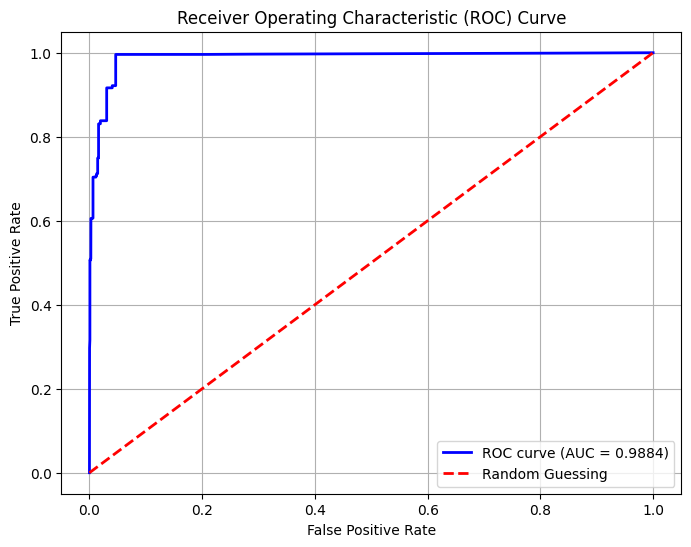

In [123]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the data
X = df['Error']  # Features
y = df['Label']  # Target labels

# Compute fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y, X)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


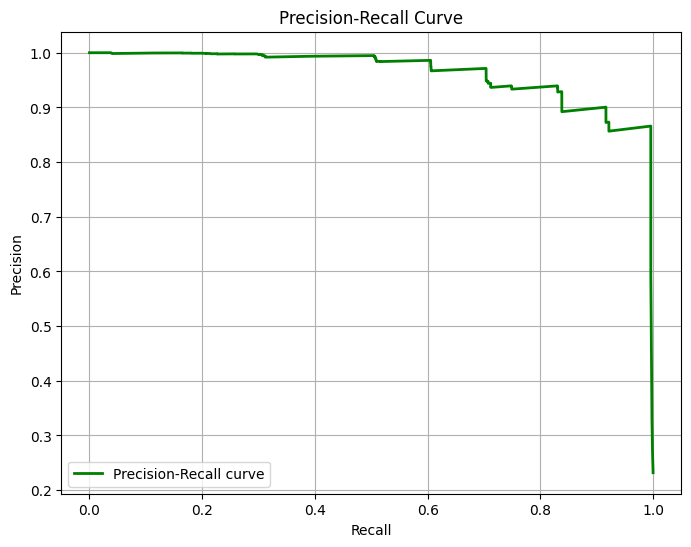

In [124]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Load the data
X = df['Error']  # Features
y = df['Label']  # Target labels

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y, X)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


In [125]:
#false positive
df[(df['Label'] == 0) & (df['Error'] > best_threshold)]

,Error,Label
6,0.002838,0.0
61,0.003720,0.0
126,0.002920,0.0
131,0.003752,0.0
133,0.003752,0.0
...,...,...
55799,0.006225,0.0
55801,0.008818,0.0
55805,0.005199,0.0
55808,0.003777,0.0


In [126]:
#false negative
df[(df['Label'] == 1) & ((df['Error'] < best_threshold) | (df['Error'] == best_threshold))]

,Error,Label
66703,0.000369,1.0
66725,0.000369,1.0
66742,0.000410,1.0
66745,0.000410,1.0
66747,0.000331,1.0
...,...,...
72023,0.000331,1.0
72025,0.000410,1.0
72064,0.000410,1.0
72071,0.000331,1.0
